<a href="https://colab.research.google.com/github/MishterBluesky/ColabTree/blob/main/ATree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ATree*** (A3M to Phylogenetic Tree)

 This software made by the Rodrigues Lab takes a3m files produced by MMSEQ2 (UniProtDB) and produces a phylogenetic tree including species name of that a3m file through various data transformations. It also produces a downloadable .svg of that phylogenetic tree.

 You can now understand what sequences were used by tools that use a3m files such as [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.2.0/AlphaFold2.ipynb), [ConservFold](https://colab.research.google.com/drive/1s7N6w2VEjadkJVS9bFzyOLaFZ3uImS0k?usp=sharing) and CoEVFold (Co-evolution calculator which uses GREMLIN coming soon).

 This software is made possible thanks to the open source software for phylogeny calculatation '[FastME](http://www.atgc-montpellier.fr/fastme/)' , toytree for the phylogeny viewing as well as the Uniprot database and associated bioservices. We also recommend you view the .nwk file created on the iTOL interactive tree of life server.

 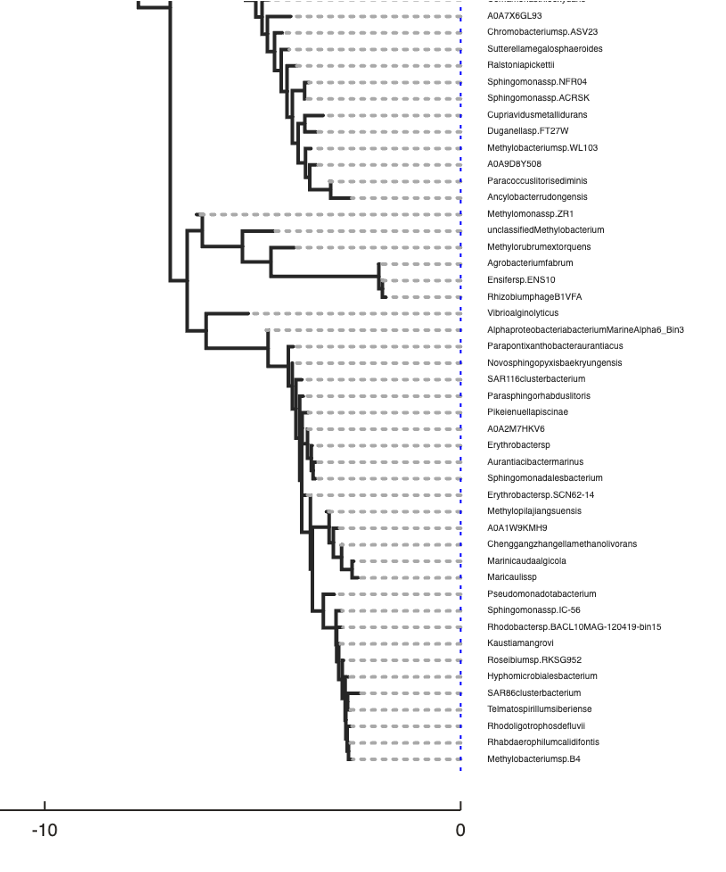



In [ ]:
#@title Upload a3m file
#@markdown We will assume the first sequence is the input sequence
from google.colab import files

# Upload the file
uploaded = files.upload()

# Extract the file name from the uploaded dictionary
file_name = list(uploaded.keys())[0]

# Now you can use the file name as 'a3m_file'
a3m_file = file_name

# Open the input file and read its contents
with open(file_name, 'r') as a3m_file:
    content = a3m_file.read()

# Convert the content to uppercase
uppercase_content = content.upper()

# Write the uppercase content to the output file
with open(file_name, 'w') as a3m_file:
    a3m_file.write(uppercase_content)

print("File name set as 'a3m_file':", a3m_file)


In [ ]:
#@title Download FastME
!git clone https://gite.lirmm.fr/atgc/FastME.git
%cd FastME
!./configure
!make install











In [ ]:
!pip install biopython
%cd '/content'
# Specify the path to your A3M file
a3m_file = f'{file_name}'



In [ ]:
#@title Turn a3m file into a PHYLIP alignment file, add species names
import warnings
from Bio import BiopythonWarning

# Filter out the specific deprecation warning
warnings.filterwarnings("ignore", category=BiopythonWarning)
import requests
import re
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

def extract_sequence_id(header):
    # Extract the sequence identifier from the header
    return header.split('_')[1]

def pad_sequences(sequences):
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = [seq + '-' * (max_length - len(seq)) for seq in sequences]
    return padded_sequences

import requests

def fetch_species_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        if url.startswith("https://rest.uniprot.org/uniparc/"):
            data = response.json()
            if "uniParcCrossReferences" in data and len(data["uniParcCrossReferences"]) > 0:
                organism = data["uniParcCrossReferences"][0].get("organism")
                if organism:
                    species = organism.get("scientificName")
                    if species:
                        return species
        else:  # Assuming it's a Uniprot URL
            fasta_data = response.text.split('\n')
            for line in fasta_data:
                if line.startswith(">"):
                    # Extract genus and species from the header line
                    species = re.split(r"OX=|/", line.split("OS=")[1])[0]
                    return species.replace(" ", ".")
    return None

def get_species(uniprot_id):
    urls = [
        f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta",
        f"https://rest.uniprot.org/uniparc/{uniprot_id}"
    ]

    for url in urls:
        species = fetch_species_from_url(url)
        if species:
            # Ensure the species name does not exceed 50 characters
            if len(species) > 50:
                species = species[:50]
            return species

    # Return the UniProt ID if species name not found
    return uniprot_id

def convert_a3m_to_phylip(a3m_file, phylip_file):
    # Parse A3M file to get sequence identifiers and sequences
    seq_records = []
    seen_ids = set()  # Set to store seen sequence identifiers
    with open(a3m_file, 'r') as f:
        skip_next = False  # Flag to skip the next line if a duplicate header is encountered
        for line in f:
            # Skip lines starting with '#' (comment lines)
            if line.startswith('#'):
                continue

            if skip_next:
                skip_next = False
                continue

            if line.startswith('>'):
                # This is a header line
                if not '_' in line:
                    # If no underscore, generate a sequential identifier ('A', 'B', 'C', etc.)
                    seq_id = 'Input Sequence'
                else:
                    seq_id = extract_sequence_id(line.strip().split('\t')[0][1:])  # Extract the desired part of the sequence identifier

                # Retrieve the species name from UniProt and update the seq_id
                species = get_species(seq_id)
                seq_id = species.replace(" ", ".")

                # Check if the sequence identifier is already in seen_ids
                if seq_id in seen_ids:
                    skip_next = True  # Set flag to skip the next line (sequence line)
                    continue
                else:
                    seen_ids.add(seq_id)
                    seq_records.append(SeqRecord('', id=seq_id))  # Create a SeqRecord with an empty sequence
            else:
                # This is a sequence line
                if not seq_records:
                    # Create a new SeqRecord if seq_records is empty
                    seq_records.append(SeqRecord('', id='Unknown'))
                seq_records[-1].seq += line.strip()  # Append the sequence to the last SeqRecord

    # Pad sequences to the same length
    padded_sequences = pad_sequences([str(seq_record.seq) for seq_record in seq_records])

    # Update SeqRecords with padded sequences
    for i, seq_record in enumerate(seq_records):
        seq_record.seq = Seq(padded_sequences[i])

    # Write to PHYLIP file
    with open(phylip_file, 'w') as f:
        AlignIO.write(MultipleSeqAlignment(seq_records), f, "phylip-relaxed")


# Specify the path to save the PHYLIP file
phylip_file = 'phylip.txt'

# Convert A3M to PHYLIP
convert_a3m_to_phylip(a3m_file, phylip_file)
# Open the PHYLIP file for reading
with open('phylip.txt', 'r') as f:
    # Read the first line from the file
    first_line = f.readline().strip()
    with open('named.fasta', 'w') as f:
        AlignIO.write(MultipleSeqAlignment(seq_records), f, "fasta")


# Split the first line by whitespace and get the first element
first_number = first_line.split()[0]

# Now first_number contains the first number from the first line of phylip.txt
print("Species count", first_number)

In [ ]:
with open('phylip.txt', 'rb') as f:
  phylip = content = f.read()
  phylip = phylip.replace(b'\x00', b'-')
  phylip = phylip.replace(b'>', b'-')
  phylip = phylip.replace(b'/', b'.')
with open('phylip.txt', 'wb') as f:
        f.write(phylip)

In [ ]:
#@title Calculate Phylogenetic tree using FASTME
%cd /content/
!fastme -i 'phylip.txt' -p
!mv phylip.txt_fastme_tree.nwk phylip_fastme_tree.nwk

In [ ]:
#@title Make your tree
!pip install toytree
import toytree
tree = toytree.tree('phylip_fastme_tree.nwk')
# Draw the tree
first_number = int(first_number)
height_value = round((first_number / 200) * 2000)
mystyle = {
    "tip_labels_style": {
        "font-size": "5px"
    }
}
canvas, axes, makr= tree.draw(width=800, height = height_value, tip_labels=True, tip_labels_align=True, **mystyle)
# show the axes coordinates
axes.show = True
axes.x.ticks.show = True
axes.y.ticks.show = True

# overlay a grid
axes.vlines(0, style={"stroke": "blue", "stroke-dasharray": "2,4"});
import toyplot.svg
toyplot.svg.render(canvas, "tree.svg")

canvas, axes, makr= tree.draw(width=800, height = height_value, tip_labels=True, tip_labels_align=True, **mystyle)
# show the axes coordinates
axes.show = True
axes.x.ticks.show = True
axes.y.ticks.show = True

# overlay a grid
axes.vlines(0, style={"stroke": "blue", "stroke-dasharray": "2,4"});

In [ ]:
#@title Download tree
files.download("tree.svg")
files.download("phylip_fastme_tree.nwk")
files.download("phylip.txt")
files.download("named.fasta")